# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    ## Prior range for log-parameters: k_1, k_2 ~ U(-1.5, 0)
    p_samples = np.random.uniform(low=(-1.5, -1.5), high=(0., 0.), size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction         
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition
sigma = 0.015   # noise standard deviation
n_obs = 11
time_points = np.linspace(0, 10, n_obs)


def batch_simulator(prior_samples, n_obs):   
    """
    Simulate multiple conversion model datasets via analytical solution of ODE
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations  
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²)
        
    return sim_data   

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [5]:
summary_net = None
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.

In [6]:
generative_model = GenerativeModel(prior, batch_simulator)

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True,
)

In [8]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
    learning_rate = lr_schedule,
    checkpoint_path = './CR11_uniform_5ACB_[64,64,64]_ckpts',
    max_to_keep=300,
    skip_checks=True
)

Networks loaded from ./CR11_uniform_5ACB_[64,64,64]_ckpts\ckpt-300


### Online training

In [ ]:
%%time
losses = trainer.train_online(epochs=300, iterations_per_epoch=1000, batch_size=128, n_obs=n_obs)

## Computational faithfulness

In [9]:
# Demo dataset 1
param_prior = np.array([[-0.1, -1.45]]).astype(np.float32)   # Ground truth parameters 
x_data = np.array([[-0.00327926,  0.52125436,  0.7631685 ,  0.86601007,  0.9218816 ,
         0.96663177,  0.95785785,  0.95275915,  0.9759764 ,  0.94804746,
         0.9484255 ]]).astype(np.float32)
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior

In [9]:
# Demo dataset 2
param_prior = np.array([[-1.45, -0.5 ]]).astype(np.float32)   # Ground truth parameters 
x_data = np.array([[0.00309283, 0.0295512 , 0.03696091, 0.05732411, 0.08041877,
        0.09214454, 0.09818493, 0.09068943, 0.11193463, 0.10281076,
        0.11628069]]).astype(np.float32)
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior

In [9]:
# Demo dataset 3 (!!!)
param_prior = np.array([[-0.5, -1.45]]).astype(np.float32)   # Ground truth parameters 
x_data = np.array([[-0.01434608,  0.25525254,  0.46928036,  0.5668125 ,  0.66839063,
         0.75689214,  0.7887045 ,  0.8237275 ,  0.8661619 ,  0.84209055,
         0.90820974]]).astype(np.float32)
n_post_samples = 7500 
param_samples = amortizer.sample(x_data, n_post_samples)   # BayesFlow samples from the learned posterior

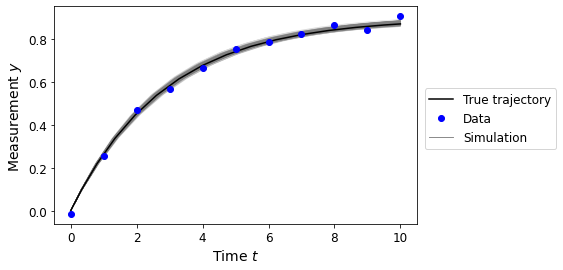

In [10]:
# Posterior predictive check
fig = plt.figure(figsize=(6.5, 4))
plt.rcParams['font.size'] = 12

for k in range(301):
    rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    if k == 0:
        plt.plot(sol.t[0], sol.y[1][0], color='grey', label='Simulation', linewidth=0.9)
    else: 
        plt.plot(sol.t, sol.y[1], color='grey', linewidth=0.5, alpha=0.3)

rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
plt.plot(sol.t, sol.y[1], color='black', label='True trajectory')    
plt.plot(time_points, x_data[0], 'o', color='blue', label='Data')

plt.xlabel('Time $t$', fontsize=14)
plt.ylabel('Measurement $y$', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12, bbox_to_anchor=(1.4,0.65))
plt.show()
fig.savefig("figures/{}_Re-simulation.png".format('CR11_uniform_3'), dpi=600, bbox_inches='tight')

In [11]:
def prior_eval(x,y):   
    # Evaluates prior probability p(theta) according to k_1, k_2 ~ U(-1.5, 0)
    if x > -1.5 and x < 0. and y > -1.5 and y < 0.:
        return 1/2.25
    else:
        return 0.

def likelihood(x,y):   
    # Calculates likelihood p(x_{1:N} | theta)
    x = 10**x
    y = 10**y
    s = x + y
    b = x/s
    state_2 = lambda t: b - b * np.exp(-s*t)
    sol = state_2(time_points)
    residual = (x_data[0] - sol)/sigma
    nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
    return np.exp(-nllh)

def unnormalized_posterior(x,y):   
    # Evaluates the unnormalized posterior probability p(theta | x_{1:N}) according to Bayes' formula
    return likelihood(x,y) * prior_eval(x,y)

In [12]:
# Scaling factor
scaling_factor = dblquad(unnormalized_posterior, -1.5, 0., lambda y: -1.5, lambda y: 0.)
print(scaling_factor)

# Normalized posterior
posterior_xy = lambda x,y: unnormalized_posterior(x,y)/scaling_factor[0]
posterior_eval = lambda theta: posterior_xy(theta[0], theta[1])
posterior_at_prior = posterior_eval(param_prior[0])
print(posterior_at_prior)

(2996701906.4872966, 860.7116055121769)
461.29179791660823


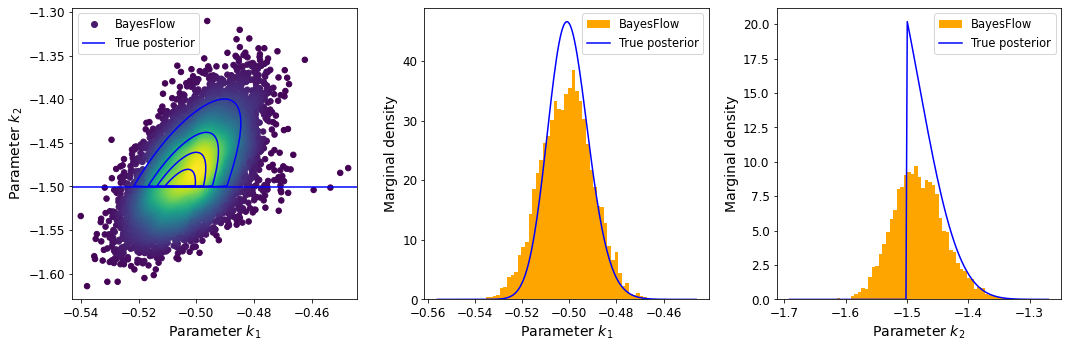

In [20]:
# Plot analytic vs. approximate posterior
plot_posterior_uniform(param_samples=param_samples, posterior_xy=posterior_xy, 
               bounds=np.array([-1.5, 0., -1.5, 0.]), levels=np.array([0,100,350,600,850]), filename='CR11_uniform_3')

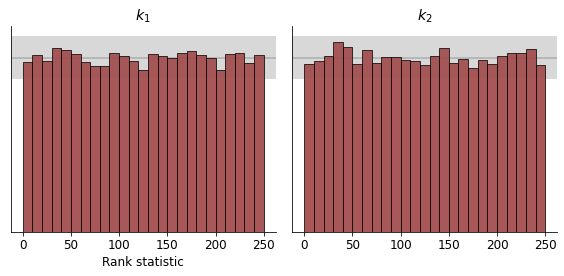

In [9]:
# Simulation-based calibration
n_sbc = 10000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$k_1$', '$k_2$'], filename='CR11_uniform')

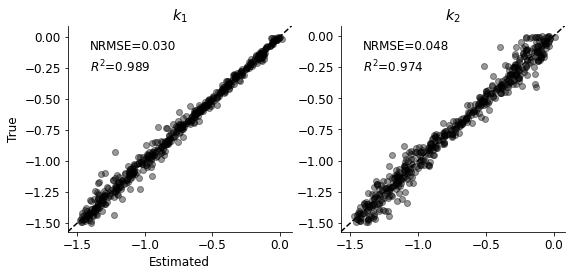

In [11]:
# Validation metrics
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$k_1$', '$k_2$'], filename='CR11_uniform')